In [1]:
!pip install -U psycopg2-binary pgvector tqdm boto3 requests scikit-image


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
%pip install --no-build-isolation --force-reinstall \
    "boto3>=1.28.57" \
    "awscli>=1.29.57" \
    "botocore>=1.31.57"

%pip install --quiet "faiss-cpu>=1.7,<2" langchain==0.0.309 "pypdf>=3.8,<4"
%pip install --upgrade sqlalchemy
%pip install progressbar

  Obtaining dependency information for boto3>=1.28.57 from https://files.pythonhosted.org/packages/8b/dc/26c1c654cb6a177fc0b7ca7f916cd61daf045a42ca091fce44906d65be9f/boto3-1.34.16-py3-none-any.whl.metadata
  Using cached boto3-1.34.16-py3-none-any.whl.metadata (6.6 kB)
  Obtaining dependency information for awscli>=1.29.57 from https://files.pythonhosted.org/packages/a6/b0/35662c2354f7f000aefb874ae09ca94b4880d49255af06704d867c91938b/awscli-1.32.16-py3-none-any.whl.metadata
  Using cached awscli-1.32.16-py3-none-any.whl.metadata (11 kB)
  Obtaining dependency information for botocore>=1.31.57 from https://files.pythonhosted.org/packages/6d/84/36a78ba9d992baf3ed48dc0ad2bdb711d27033de0b088d71f4cfcd698bde/botocore-1.34.16-py3-none-any.whl.metadata
  Using cached botocore-1.34.16-py3-none-any.whl.metadata (5.6 kB)
  Using cached jmespath-1.0.1-py3-none-any.whl (20 kB)
  Obtaining dependency information for s3transfer<0.11.0,>=0.10.0 from https://files.pythonhosted.org/packages/12/bb/7e7912e

In [4]:
import urllib.request
import os
import json
import boto3
from multiprocessing import cpu_count
from tqdm.contrib.concurrent import process_map
filename = 'metadata.json'

def download_metadata(url):
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

## The German text has been translated into English and the resulting translation has been stored in this repository for convenience.
download_metadata('https://raw.githubusercontent.com/aws-samples/rds-postgresql-pgvector/master/data/FEIDEGGER_release_1.2.json')

with open(filename) as json_file:
    results = json.load(json_file)

results[0]

{'url': 'https://img01.ztat.net/article/spp-media-p1/3c8812d8b6233a55a5da06b19d780302/dc58460c157b426b817f13e7a2f087c5.jpg?imwidth=400&filter=packshot',
 'descriptions': ['short, sexy, summer, sexy, party, yellow dress, and sleeveless',
  'A yellow dress which is up to about above the knee and has a V-neckline. The dress has a strapless accent',
  'Knee-length fabric dress in yellow with wide skirt, off-the-shoulder with a deep round neckline.',
  'Yellow sleeveless summer dress. It has a slightly rounded V-neck. The dress is longer at the back than at the front.',
  'Airy summer dress that is slightly longer at the back. It is sleeveless, has a v-neck and wide straps.'],
 'split': '7'}

In [5]:
data = {
  "inputs": ' '.join(results[0].get('descriptions'))
}

data

{'inputs': 'short, sexy, summer, sexy, party, yellow dress, and sleeveless A yellow dress which is up to about above the knee and has a V-neckline. The dress has a strapless accent Knee-length fabric dress in yellow with wide skirt, off-the-shoulder with a deep round neckline. Yellow sleeveless summer dress. It has a slightly rounded V-neck. The dress is longer at the back than at the front. Airy summer dress that is slightly longer at the back. It is sleeveless, has a v-neck and wide straps.'}

In [6]:
import sagemaker
import boto3
sess = sagemaker.Session()

bedrock_bucket = "reinvent-retail-store-artifacts"

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {bedrock_bucket}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker role arn: arn:aws:iam::626103420214:role/service-role/AmazonSageMaker-ExecutionRole-20230605T102443
sagemaker bucket: reinvent-retail-store-artifacts


In [6]:
import json
import os
import sys
import boto3
from utils import bedrock, print_ww

module_path = ".."
sys.path.append(os.path.abspath(module_path))
from utils import bedrock, print_ww

#initialize Bedrock client
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None)
)

Create new client
  Using region: us-east-1
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)


In [7]:
from langchain.embeddings import BedrockEmbeddings
from langchain.llms.bedrock import Bedrock

# create Titan embeddings model

modelId = "amazon.titan-embed-g1-text-02"
bedrock_embeddings = BedrockEmbeddings(model_id=modelId, client=boto3_bedrock)
print(bedrock_embeddings.model_id)

amazon.titan-embed-g1-text-02


In [9]:
import numpy as np

description = ''
for result in results[0]['descriptions']:
    description = description + ''.join(result)
print(description)
sample_embedding = np.array(bedrock_embeddings.embed_query(description))
print(sample_embedding)
print(len(results))

short, sexy, summer, sexy, party, yellow dress, and sleevelessA yellow dress which is up to about above the knee and has a V-neckline. The dress has a strapless accentKnee-length fabric dress in yellow with wide skirt, off-the-shoulder with a deep round neckline.Yellow sleeveless summer dress. It has a slightly rounded V-neck. The dress is longer at the back than at the front.Airy summer dress that is slightly longer at the back. It is sleeveless, has a v-neck and wide straps.
[ 0.46875     0.34570312  0.26953125 ... -0.09472656 -0.10498047
  0.70703125]
8792


In [10]:
# Re-run the cell if it fails.
# Generate embeddings using Titan embeddings + Bedrock. Takes about ~45 min.

import progressbar
from time import sleep

def generate_embeddings(results, maxval):
    
    print(maxval)
    bar = progressbar.ProgressBar(maxval=maxval, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    r=[]
    j=0
    
    for data in results:
        
        try:
            l = {}
            l['url'] = data['url']
            l['descriptions'] = data['descriptions']
            l['split'] = data['split']

            description = ''
            for result in data['descriptions']:
                description = description + ''.join(result)
            vector_embeddings = list(bedrock_embeddings.embed_query(description))
            l['descriptions_embeddings'] = vector_embeddings

            r.append(l)

            j=j+1
            bar.update(j)
            sleep(0.1)
        
        except Exception as e:
            print(e)
            continue;
        
    bar.finish()
    return r

In [11]:
#subresults = results[0:7500]
data = generate_embeddings(results, len(results))

8792


[========================================================================] 100%


In [12]:
#with open("data.lst", "w") as output:
#    output.write(str(data))

In [13]:
len(data[0].get('descriptions_embeddings'))

1536

In [14]:
import psycopg2
from pgvector.psycopg2 import register_vector
import boto3 
import json 

client = boto3.client('secretsmanager')

response = client.get_secret_value(
    SecretId='postgresdb-secret'
)
database_secrets = json.loads(response['SecretString'])

dbhost = database_secrets['host']
dbport = database_secrets['port']
dbuser = database_secrets['username']
dbpass = database_secrets['password']
dbvector = database_secrets['vectorDbIdentifier']

dbconn = psycopg2.connect(host=dbhost, user=dbuser, password=dbpass, port=dbport, database=dbvector,connect_timeout=10)
dbconn.set_session(autocommit=True)

cur = dbconn.cursor()
cur.execute("CREATE EXTENSION IF NOT EXISTS vector;")
register_vector(dbconn)
cur.execute("DROP TABLE IF EXISTS vector_products;")
cur.execute("""CREATE TABLE IF NOT EXISTS vector_products(
               id bigserial primary key, 
               description text, 
               url text, 
               split int, 
               descriptions_embeddings vector(1536));""")

bar = progressbar.ProgressBar(maxval=7500, \
widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()

j=0
for x in data:
    try:
        cur.execute("""INSERT INTO vector_products
                          (description, url, split, descriptions_embeddings) 
                      VALUES(%s, %s, %s, %s);""", 
                      (' '.join(x.get('descriptions', [])), x.get('url'), x.get('split'), x.get('descriptions_embeddings')))
        j=j+1
        bar.update(j)
        sleep(0.1)
        
    except Exception as e:
        print(e)
        continue;
bar.finish()

try: 
    cur.execute("""CREATE INDEX ON vector_products
                   USING ivfflat (descriptions_embeddings vector_l2_ops) WITH (lists = 100);""")
    cur.execute("VACUUM ANALYZE vector_products;")

except Exception as e:
    print(e)

cur.close()
dbconn.close()
print ("Vector embeddings has been successfully loaded into PostgreSQL")

Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of

Value out of range
Value out of range
Value out of range
Value out of range
Value out of range
Value out of range


Vector embeddings has been successfully loaded into PostgreSQL


In [15]:
import psycopg2
from pgvector.psycopg2 import register_vector
import boto3 
import json 

client = boto3.client('secretsmanager')

response = client.get_secret_value(
    SecretId='postgresdb-secret'
)
database_secrets = json.loads(response['SecretString'])

dbhost = database_secrets['host']
dbport = database_secrets['port']
dbuser = database_secrets['username']
dbpass = database_secrets['password']
dbvector = database_secrets['vectorDbIdentifier']

dbconn = psycopg2.connect(host=dbhost, user=dbuser, password=dbpass, port=dbport, database=dbvector,connect_timeout=10)
dbconn.set_session(autocommit=True)

cur = dbconn.cursor()
cur.execute("CREATE EXTENSION IF NOT EXISTS vector;")
register_vector(dbconn)
cur.execute("""CREATE INDEX ON vector_products
               USING ivfflat (descriptions_embeddings vector_l2_ops) WITH (lists = 100);""")
cur.execute("VACUUM ANALYZE vector_products;")

cur.close()
dbconn.close()
print ("Vector embeddings has been successfully loaded into PostgreSQL")

Vector embeddings has been successfully loaded into PostgreSQL


In [33]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import requests
import psycopg2
from pgvector.psycopg2 import register_vector

data = "red dresses"

search_embedding = list(bedrock_embeddings.embed_query(data))
print("SEARCH EMBEDDINGS:\n")
print(search_embedding)

SEARCH EMBEDDINGS:

[-0.27734375, 0.984375, 0.7421875, -0.8828125, 0.74609375, 0.578125, -0.29101562, -0.0014038086, -0.15234375, -0.19042969, -0.51171875, 0.47265625, 0.546875, -0.328125, 0.38671875, -0.28125, 0.40625, -1.328125, -0.21875, 0.61328125, 0.006225586, -0.33203125, -0.25, -0.609375, -0.0126953125, -0.23925781, 0.9921875, 0.0087890625, -0.42773438, 1.015625, 0.36328125, 1.21875, -0.69140625, -0.328125, -0.35351562, -1.125, 0.765625, -0.671875, 0.23535156, 0.140625, -0.45703125, 0.09716797, 0.76953125, 1.90625, -0.0068359375, -0.515625, -0.51171875, -1.078125, -1.09375, 0.18359375, 0.15820312, 1.46875, -1.0078125, -0.50390625, 0.13964844, 1.59375, 0.359375, 0.484375, -0.5234375, -0.14355469, 0.73828125, -0.3046875, -0.083984375, 1.1875, 0.19042969, -0.07128906, 0.00390625, 1.0, 0.42578125, 0.26953125, -0.765625, -0.71875, -0.03515625, -0.09375, -1.1328125, -0.546875, -0.44726562, -0.34960938, 0.46875, 1.296875, -0.057128906, -0.20605469, -0.28515625, 0.35546875, 1.0, -0.4492

Product Item Id: 3918
Product description: Beautiful ladies dress very formal color red shirt in the middle is very slim and elegant. Long wide festive red dress with lace, sleeveless, and with a cutout knee It is a red floor-length evening dress. The straps are made of red lace and there is a slit along the leg. It has a V-neck, sleeves are missing. This is a ball gown. It is long and goes down to the ankles. It is red. The crotch has a vertical cut to guarantee legroom. It is figure-hugging. It doesn't have sleeves. A shoulder strap is available and has a floral pattern. It has a light, translucent red veil. A long burgundy dress. It has no sleeves and a wide neckline.


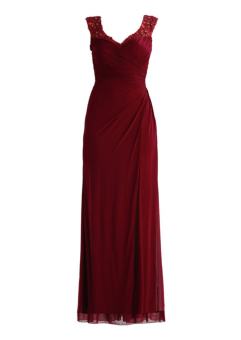

Product Item Id: 4142
Product description: A long red dress. The arms, shoulders and most of the chest are free. It has a red belt that is tied into a bow. Red long strappy dress with spaghetti straps. The wide dress has a tie belt at the waist. A long valance makes the skirt appear even more swinging. It is a red long dress with spagetti straps and without sleeves. The dress has a ribbon that accentuates the waist. Red floor-to-ceiling dress in red with thin straps and belt A burgundy, approximately ankle-length evening dress, with a half-round neckline, spagetti straps and an additional transparent ruffle at the hem.


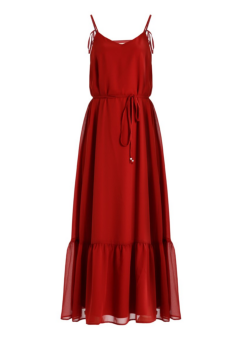

In [34]:
client = boto3.client('secretsmanager')

response = client.get_secret_value(
    SecretId='postgresdb-secret'
)
database_secrets = json.loads(response['SecretString'])

dbhost = database_secrets['host']
dbport = database_secrets['port']
dbuser = database_secrets['username']
dbpass = database_secrets['password']
dbvector = database_secrets['vectorDbIdentifier']

dbconn = psycopg2.connect(host=dbhost, user=dbuser, password=dbpass, port=dbport, database=dbvector, connect_timeout=10)
dbconn.set_session(autocommit=True)

# Register vector db
register_vector(dbconn)

cur = dbconn.cursor()
cur.execute("""SELECT id, url, description, descriptions_embeddings 
            FROM vector_products
            ORDER BY descriptions_embeddings <-> %s limit 2;""", 
            (np.array(search_embedding),))

r = cur.fetchall()

urls = []
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

for x in r:
    url = x[1].split('?')[0]
    desc = x[2]
    urldata = requests.get(url).content
    print ("Product Item Id: " + str(x[0]))
    print ("Product description: " + desc)
    a = io.imread(url)
    plt.imshow(a)
    plt.axis('off')
    plt.show()

cur.close()
dbconn.close()